# Bluetooth Sensor
The system to be analyzed in this tutorial is a very simple one: A battery operated Bluetooth sensor.   
The system consists of the following components:
  * A CR2032 3V lithium battery
  * A MCU operating at 1.8V
  * A sensor that needs 5V to operate

To power the MCU and sensor from the 3V battery two converters are needed:  
  * A boost converter that outputs 5V. The 5V is filtered with an RC filter to reduce switching noise.
  * A buck converter that outputs 1.8V


In [1]:
# This cell can be removed, it is only used for running the notebook during Sphinx documentation build.
import sys, os
if os.getcwd().replace('\\', '/').endswith("/docs/nb"):
    sys.path.insert(0, os.path.abspath(os.path.join("../../src")))

In [2]:
from sysloss.components import *
from sysloss.system import System

## Define the system
A sysloss system is defined using the System class. Components are added to the system, always starting with a Source component (in this case the battery). Each component must have a unique name. 

Parameters for voltage, current, power and resistance are always in basic units of electricity (Volt, Ampere, Watt and Ohm).


In [3]:
bts = System("Bluetooth sensor", Source("CR2032", vo=3.0, rs=10))
bts.add_comp("CR2032", comp=Converter("Buck 1.8V", vo=1.8, eff=0.87))
bts.add_comp("Buck 1.8V", comp=PLoad("MCU", pwr=13e-3))
bts.add_comp("CR2032", comp=Converter("Boost 5V", vo=5.0, eff=0.82, iis=3e-6))
bts.add_comp("Boost 5V", comp=RLoss("RC filter", rs=6.8))
bts.add_comp("RC filter", comp=ILoad("Sensor", ii=6e-3))

That's it - for the initial system! sysloss has two functions for summarizing the system:
  * *.tree()* that displays the power tree structure
  * *.params()* that lists all system parameters in a Pandas frame

In [4]:
bts.tree()

Bluetooth sensor
└── CR2032
    ├── Boost 5V
    │   └── RC filter
    │       └── Sensor
    └── Buck 1.8V
        └── MCU

In [5]:
bts.params()

,Component,Type,vo (V),vdrop (V),rs (Ohm),rt (°C/W),eff (%),ig (A),iq (A),ii (A),iis (A),pwr (W),pwrs (W),loss
0,CR2032,SOURCE,3.0,,10,0.0,,,,,,,,
1,Boost 5V,CONVERTER,5.0,,,0.0,0.82,,0.0,,0.000003,,,
2,RC filter,SLOSS,,,6.8,0.0,,,,,,,,
3,Sensor,LOAD,,,,0.0,,,,0.006,0.0,,,False
4,Buck 1.8V,CONVERTER,1.8,,,0.0,0.87,,0.0,,0.0,,,
5,MCU,LOAD,,,,0.0,,,,,,0.013,0.0,False


## Analyze
We can now analyze the steady-state of this system with *.solve()*, which returns the system state in a Pandas frame.

In [6]:
bts.solve()

,Component,Type,Parent,Vin (V),Vout (V),Iin (A),Iout (A),Power (W),Loss (W),Efficiency (%),Warnings
0,CR2032,SOURCE,,3.0,2.817088,0.018291,0.018291,0.054874,0.003346,93.902943,
1,Boost 5V,CONVERTER,CR2032,2.817088,5.0,0.012987,0.006,0.036585,0.006585,82.0,
2,RC filter,SLOSS,Boost 5V,5.0,4.9592,0.006,0.006,0.03,0.000245,99.184,
3,Sensor,LOAD,RC filter,4.9592,0.0,0.006,0.0,0.029755,0.0,100.0,
4,Buck 1.8V,CONVERTER,CR2032,2.817088,1.8,0.005304,0.007222,0.014943,0.001943,87.0,
5,MCU,LOAD,Buck 1.8V,1.8,0.0,0.007222,0.0,0.013,0.0,100.0,
6,System total,,,,,,0.018291,0.054874,0.012118,77.915822,


## Voltage rails
In this simple system there are three voltage rails:
  * Battery voltage
  * 1.8V
  * 5V

We can give these voltage rails a name when components are added to the system. The voltage rail names are added to the results table, which can be useful especially in large power trees. 
```{tip}
The power rail name can be used instead of component name as parent parameter when adding components to the system.
```
Let's redefine the system, adding voltage rail names:

In [7]:
bts = System("Bluetooth sensor", Source("CR2032", vo=3.0, rs=10), rail="VBat")
bts.add_comp("VBat", comp=Converter("Buck 1.8V", vo=1.8, eff=0.87), rail="SYS_1V8")
bts.add_comp("SYS_1V8", comp=PLoad("MCU", pwr=13e-3))
bts.add_comp("VBat", comp=Converter("Boost 5V", vo=5.0, eff=0.82, iis=3e-6), rail="SYS_5V")
bts.add_comp("SYS_5V", comp=RLoss("RC filter", rs=6.8), rail="5V_quiet")
bts.add_comp("5V_quiet", comp=ILoad("Sensor", ii=6e-3))
bts.solve()

,Component,Type,Rail in,Vin (V),Vout (V),Rail out,Iin (A),Iout (A),Power (W),Loss (W),Efficiency (%),Warnings
0,CR2032,SOURCE,,3.0,2.817088,VBat,0.018291,0.018291,0.054874,0.003346,93.902943,
1,Boost 5V,CONVERTER,VBat,2.817088,5.0,SYS_5V,0.012987,0.006,0.036585,0.006585,82.0,
2,RC filter,SLOSS,SYS_5V,5.0,4.9592,5V_quiet,0.006,0.006,0.03,0.000245,99.184,
3,Sensor,LOAD,5V_quiet,4.9592,0.0,,0.006,0.0,0.029755,0.0,100.0,
4,Buck 1.8V,CONVERTER,VBat,2.817088,1.8,SYS_1V8,0.005304,0.007222,0.014943,0.001943,87.0,
5,MCU,LOAD,SYS_1V8,1.8,0.0,,0.007222,0.0,0.013,0.0,100.0,
6,System total,,,,,,,0.018291,0.054874,0.012118,77.915822,


## Load phases
Very few systems operate with constant power. Most systems will have two or more operating modes, where different parts of the system is shut-down or operating at lower or higher power. Our Bluetooth sensor will acquire and transmit sensor data once per hour and stay in sleep mode otherwise. 

sysloss captures these operating modes with *load phases*. We define three phases:
  * "sleep": the 5V boost converter is shut-down (and the sensor with it). MCU is sleeping.
  * "acquire": the 5V boost converter is enabled, MCU is acquiring sensor data.
  * "transmit": the MCU uses higher power to transmit sensor data, while the 5V boost converter is shut-down.

Load phases in sysloss are defined in a dict with name and duration (seconds) of each phase. The duration values are used to calculate time-averaged power numbers. We start by defining the load phases on system level.


In [8]:
bts_phases = {"sleep": 3600, "acquire": 2.5, "transmit": 2e-3}
bts.set_sys_phases(bts_phases)

To define which load phases a converter is active in, we set the converter parameter *active_phases*, which is a list of phases. 
```{tip}
When a converter is shut-down, the output voltage is 0.0, and all components connected to it will be off too. There is no need to define load phases for those components.
```

In [9]:
bts.set_comp_phases("Boost 5V", phase_conf=["acquire"])

Next, we set the load phases for the MCU, which has different power for each phase. For load components the load phase power consumption is defined as a dict.

In [10]:
mcu_pwr = {"sleep": 12e-6, "acquire": 15e-3, "transmit": 35e-3}
bts.set_comp_phases("MCU", phase_conf=mcu_pwr)

The *.phases()* function returns a DataFrame with the load phases summarized:

In [11]:
bts.phases()

,Component,Type,Parent,Active phase,rs (Ohm),ii (A),pwr (W)
0,CR2032,SOURCE,,N/A,,,
1,Boost 5V,CONVERTER,CR2032,acquire,,,
2,RC filter,SLOSS,Boost 5V,N/A,,,
3,Sensor,LOAD,RC filter,N/A,,0.006,
4,Buck 1.8V,CONVERTER,CR2032,N/A,,,
5,MCU,LOAD,Buck 1.8V,sleep,,,0.000012
6,MCU,LOAD,Buck 1.8V,acquire,,,0.015
7,MCU,LOAD,Buck 1.8V,transmit,,,0.035


Analyzing again:

In [12]:
bts.solve()

,Component,Type,Rail in,Phase,Vin (V),Vout (V),Rail out,Iin (A),Iout (A),Power (W),Loss (W),Efficiency (%),Warnings
0,CR2032,SOURCE,,sleep,3.0,2.999924,VBat,0.000008,0.000008,0.000023,0.0,99.997467,
1,Boost 5V,CONVERTER,VBat,sleep,2.999924,0.0,SYS_5V,0.000003,0.0,0.000009,0.000009,0.0,
2,RC filter,SLOSS,SYS_5V,sleep,0.0,0.0,5V_quiet,0.0,0.0,0.0,0.0,100.0,
3,Sensor,LOAD,5V_quiet,sleep,0.0,0.0,,0.0,0.0,0.0,0.0,100.0,
4,Buck 1.8V,CONVERTER,VBat,sleep,2.999924,1.8,SYS_1V8,0.000005,0.000007,0.000014,0.000002,87.0,
5,MCU,LOAD,SYS_1V8,sleep,1.8,0.0,,0.000007,0.0,0.000012,0.0,100.0,
6,System total,,,sleep,,,,,0.000008,0.000023,0.000011,52.646258,
7,CR2032,SOURCE,,acquire,3.0,2.808332,VBat,0.019167,0.019167,0.0575,0.003674,93.611075,
8,Boost 5V,CONVERTER,VBat,acquire,2.808332,5.0,SYS_5V,0.013027,0.006,0.036585,0.006585,82.0,
9,RC filter,SLOSS,SYS_5V,acquire,5.0,4.9592,5V_quiet,0.006,0.006,0.03,0.000245,99.184,


The result table now has a new column **Phase**, results for each phase and a system average row.

## Parameter interpolation
The converters in the system have been defined with constant efficiency. Converter efficiency is a function of many factors, including output current and input voltage. sysloss supports interpolation of converter efficiency. This means that we can take data points from the converter data sheet (or measurement data from a lab test) and provide these data points to sysloss as an interpolated parameter. sysloss will then connect the dots with 1D or 2D linear interpolation. 

Let us define the efficiency curve for the 1.8V buck converter. The data points are entered in a dict with a specific format:

In [13]:
buck_eff = {"vi": [3.0], "io": [1e-6, 1e-5, 1e-4, 1e-3, 1e-2], "eff": [[0.72, 0.89, 0.92, 0.925, 0.93]]}
bts.change_comp("Buck 1.8V", comp=Converter("Buck 1.8V", vo=1.8, eff=buck_eff))

In [14]:
bts.params()

,Component,Type,vo (V),vdrop (V),rs (Ohm),rt (°C/W),eff (%),ig (A),iq (A),ii (A),iis (A),pwr (W),pwrs (W),loss
0,CR2032,SOURCE,3.0,,10,0.0,,,,,,,,
1,Boost 5V,CONVERTER,5.0,,,0.0,0.82,,0.0,,0.000003,,,
2,RC filter,SLOSS,,,6.8,0.0,,,,,,,,
3,Sensor,LOAD,,,,0.0,,,,0.006,0.0,,,False
4,Buck 1.8V,CONVERTER,1.8,,,0.0,interp,,0.0,,0.0,,,
5,MCU,LOAD,,,,0.0,,,,,,0.013,0.0,False


If we look in the parameter table now, the entry for "Buck 1.8V" efficiency is *interp*, which means an interpolated parameter. We can also plot the interpolation curve with the *.plot_interp()* method:

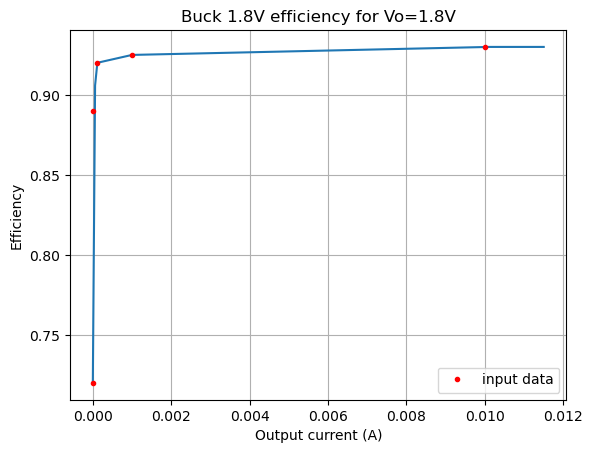

In [15]:
bts.plot_interp("Buck 1.8V");

In [16]:
bts.solve()

,Component,Type,Rail in,Phase,Vin (V),Vout (V),Rail out,Iin (A),Iout (A),Power (W),Loss (W),Efficiency (%),Warnings
0,CR2032,SOURCE,,sleep,3.0,2.999922,VBat,0.000008,0.000008,0.000024,0.0,99.997388,
1,Boost 5V,CONVERTER,VBat,sleep,2.999922,0.0,SYS_5V,0.000003,0.0,0.000009,0.000009,0.0,
2,RC filter,SLOSS,SYS_5V,sleep,0.0,0.0,5V_quiet,0.0,0.0,0.0,0.0,100.0,
3,Sensor,LOAD,5V_quiet,sleep,0.0,0.0,,0.0,0.0,0.0,0.0,100.0,
4,Buck 1.8V,CONVERTER,VBat,sleep,2.999922,1.8,,0.000005,0.000007,0.000015,0.000003,82.703704,
5,MCU,LOAD,,sleep,1.8,0.0,,0.000007,0.0,0.000012,0.0,100.0,
6,System total,,,sleep,,,,,0.000008,0.000024,0.000012,51.041607,
7,CR2032,SOURCE,,acquire,3.0,2.812515,VBat,0.018748,0.018748,0.056245,0.003515,93.750503,
8,Boost 5V,CONVERTER,VBat,acquire,2.812515,5.0,SYS_5V,0.013008,0.006,0.036585,0.006585,82.0,
9,RC filter,SLOSS,SYS_5V,acquire,5.0,4.9592,5V_quiet,0.006,0.006,0.03,0.000245,99.184,


The effect is not very large in this system, but the "sleep" efficiency is about 1.5% lower.

## Saving and loading system from file
A system can be saved to .json format with the *.save()* method. Restore the system from file with the *.from_file()* method.

In [17]:
bts.save("bts.json")

In [18]:
bts2 = System.from_file("bts.json")
bts2.solve()

,Component,Type,Rail in,Phase,Vin (V),Vout (V),Rail out,Iin (A),Iout (A),Power (W),Loss (W),Efficiency (%),Warnings
0,CR2032,SOURCE,,sleep,3.0,2.999922,VBat,0.000008,0.000008,0.000024,0.0,99.997388,
1,Buck 1.8V,CONVERTER,VBat,sleep,2.999922,1.8,,0.000005,0.000007,0.000015,0.000003,82.703704,
2,MCU,LOAD,,sleep,1.8,0.0,,0.000007,0.0,0.000012,0.0,100.0,
3,Boost 5V,CONVERTER,VBat,sleep,2.999922,0.0,SYS_5V,0.000003,0.0,0.000009,0.000009,0.0,
4,RC filter,SLOSS,SYS_5V,sleep,0.0,0.0,5V_quiet,0.0,0.0,0.0,0.0,100.0,
5,Sensor,LOAD,5V_quiet,sleep,0.0,0.0,,0.0,0.0,0.0,0.0,100.0,
6,System total,,,sleep,,,,,0.000008,0.000024,0.000012,51.041607,
7,CR2032,SOURCE,,acquire,3.0,2.812515,VBat,0.018748,0.018748,0.056245,0.003515,93.750503,
8,Buck 1.8V,CONVERTER,VBat,acquire,2.812515,1.8,,0.00574,0.008333,0.016145,0.001145,92.907407,
9,MCU,LOAD,,acquire,1.8,0.0,,0.008333,0.0,0.015,0.0,100.0,


## Summary
This notebook demonstrates the basic use of sysLoss, including load phases, component parameter interpolation and saving and loading system from file.

The natural question now is: How long will the battery last for the bluetooth sensor? Find out in the [Battery Life Simulation tutorial](batt_life_sim).